# ResNet своими лапками

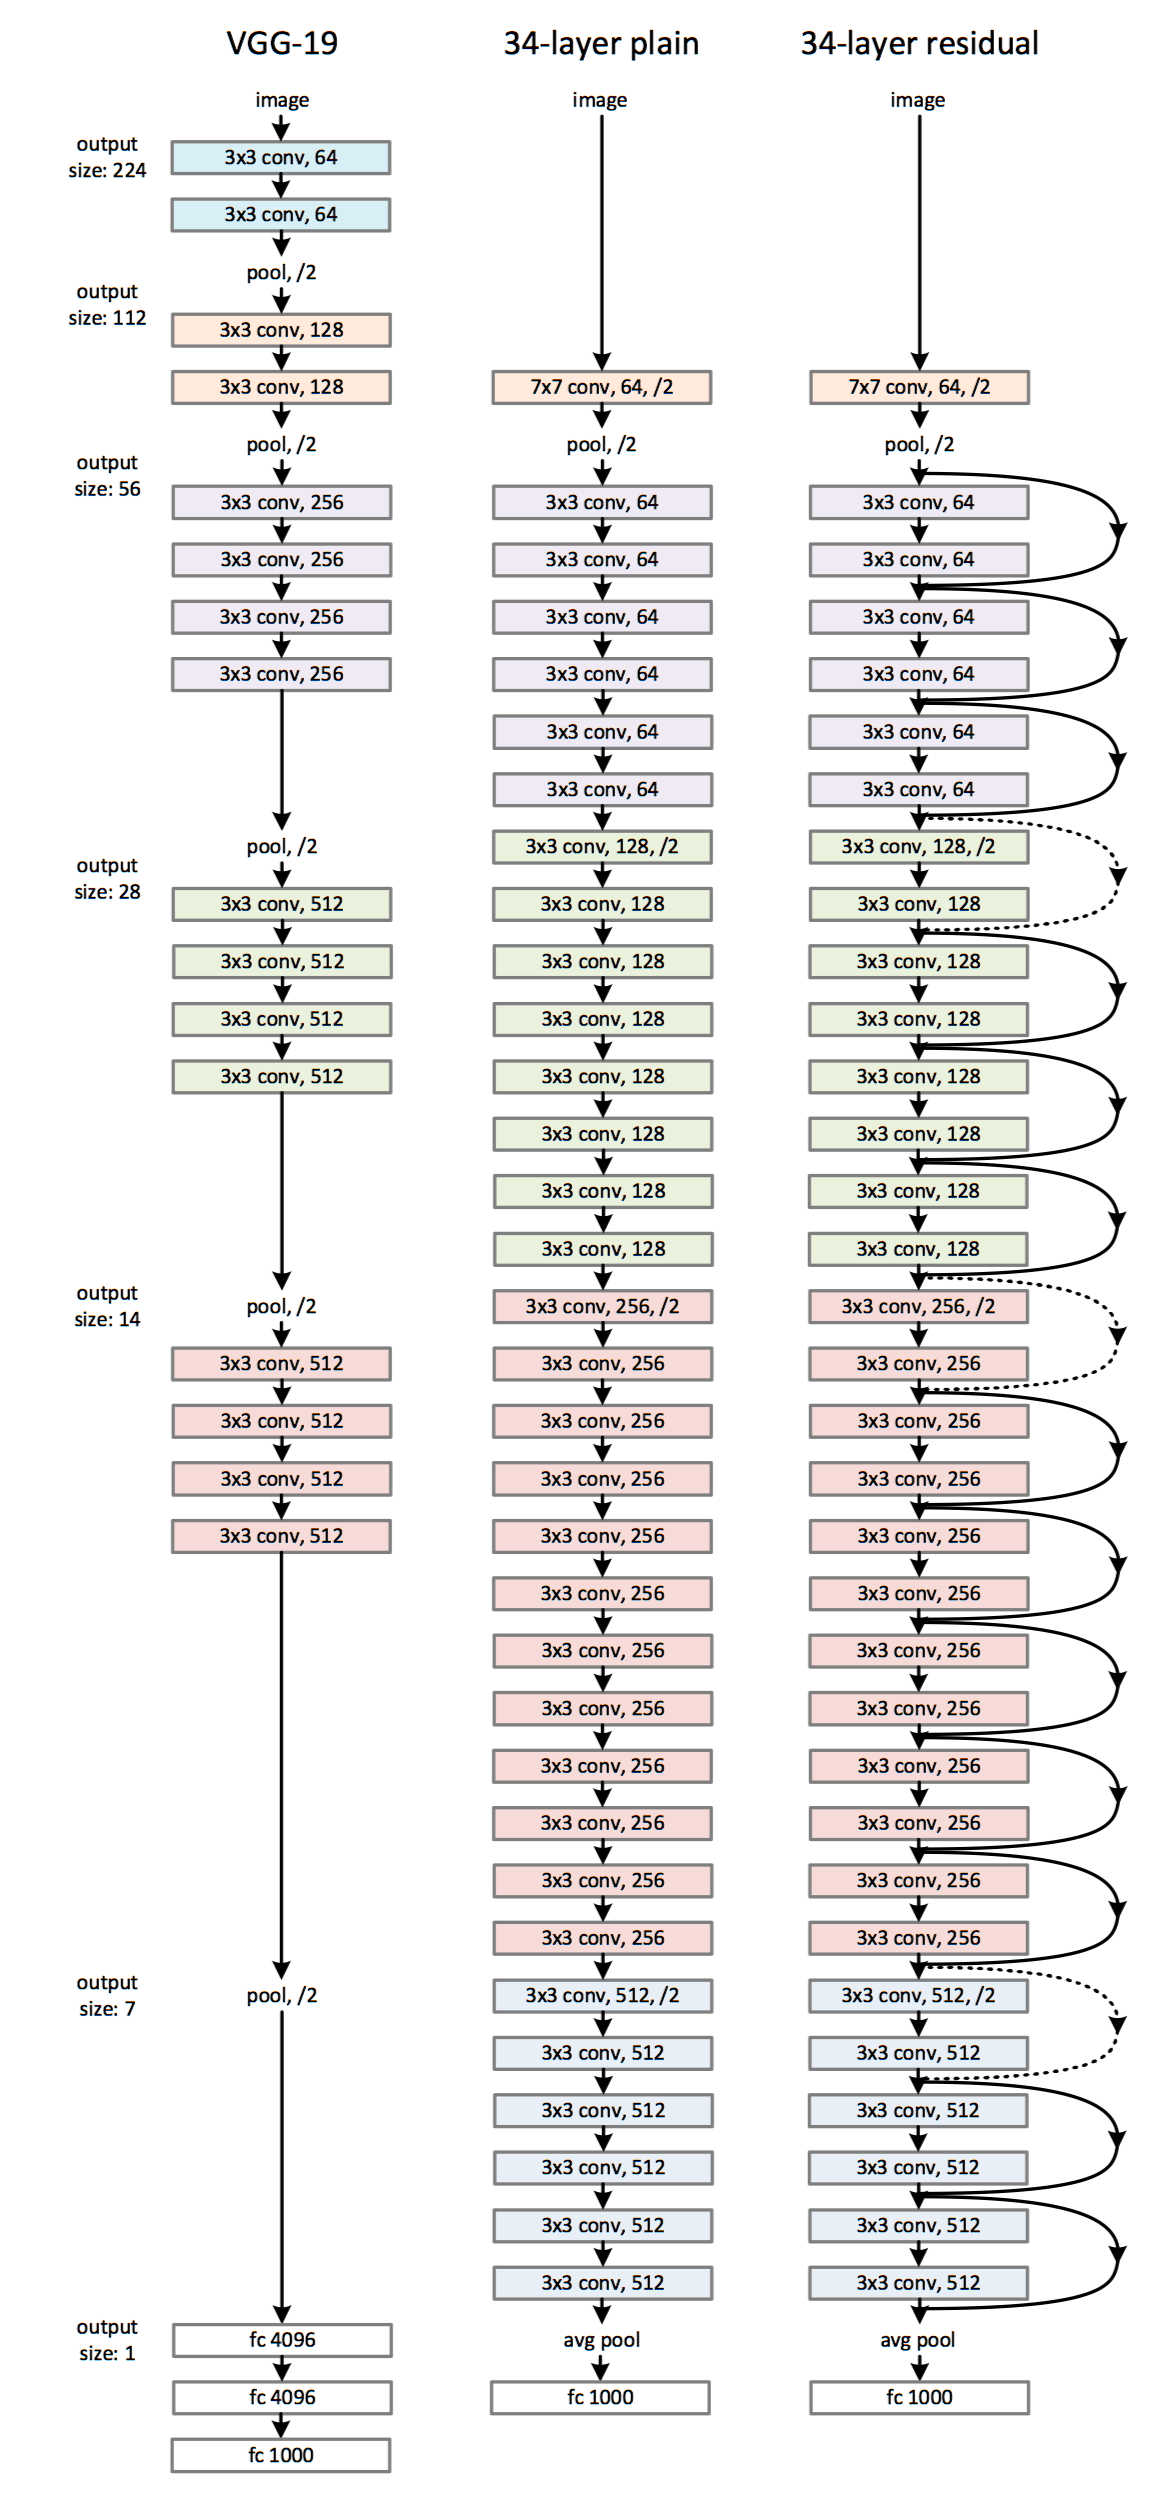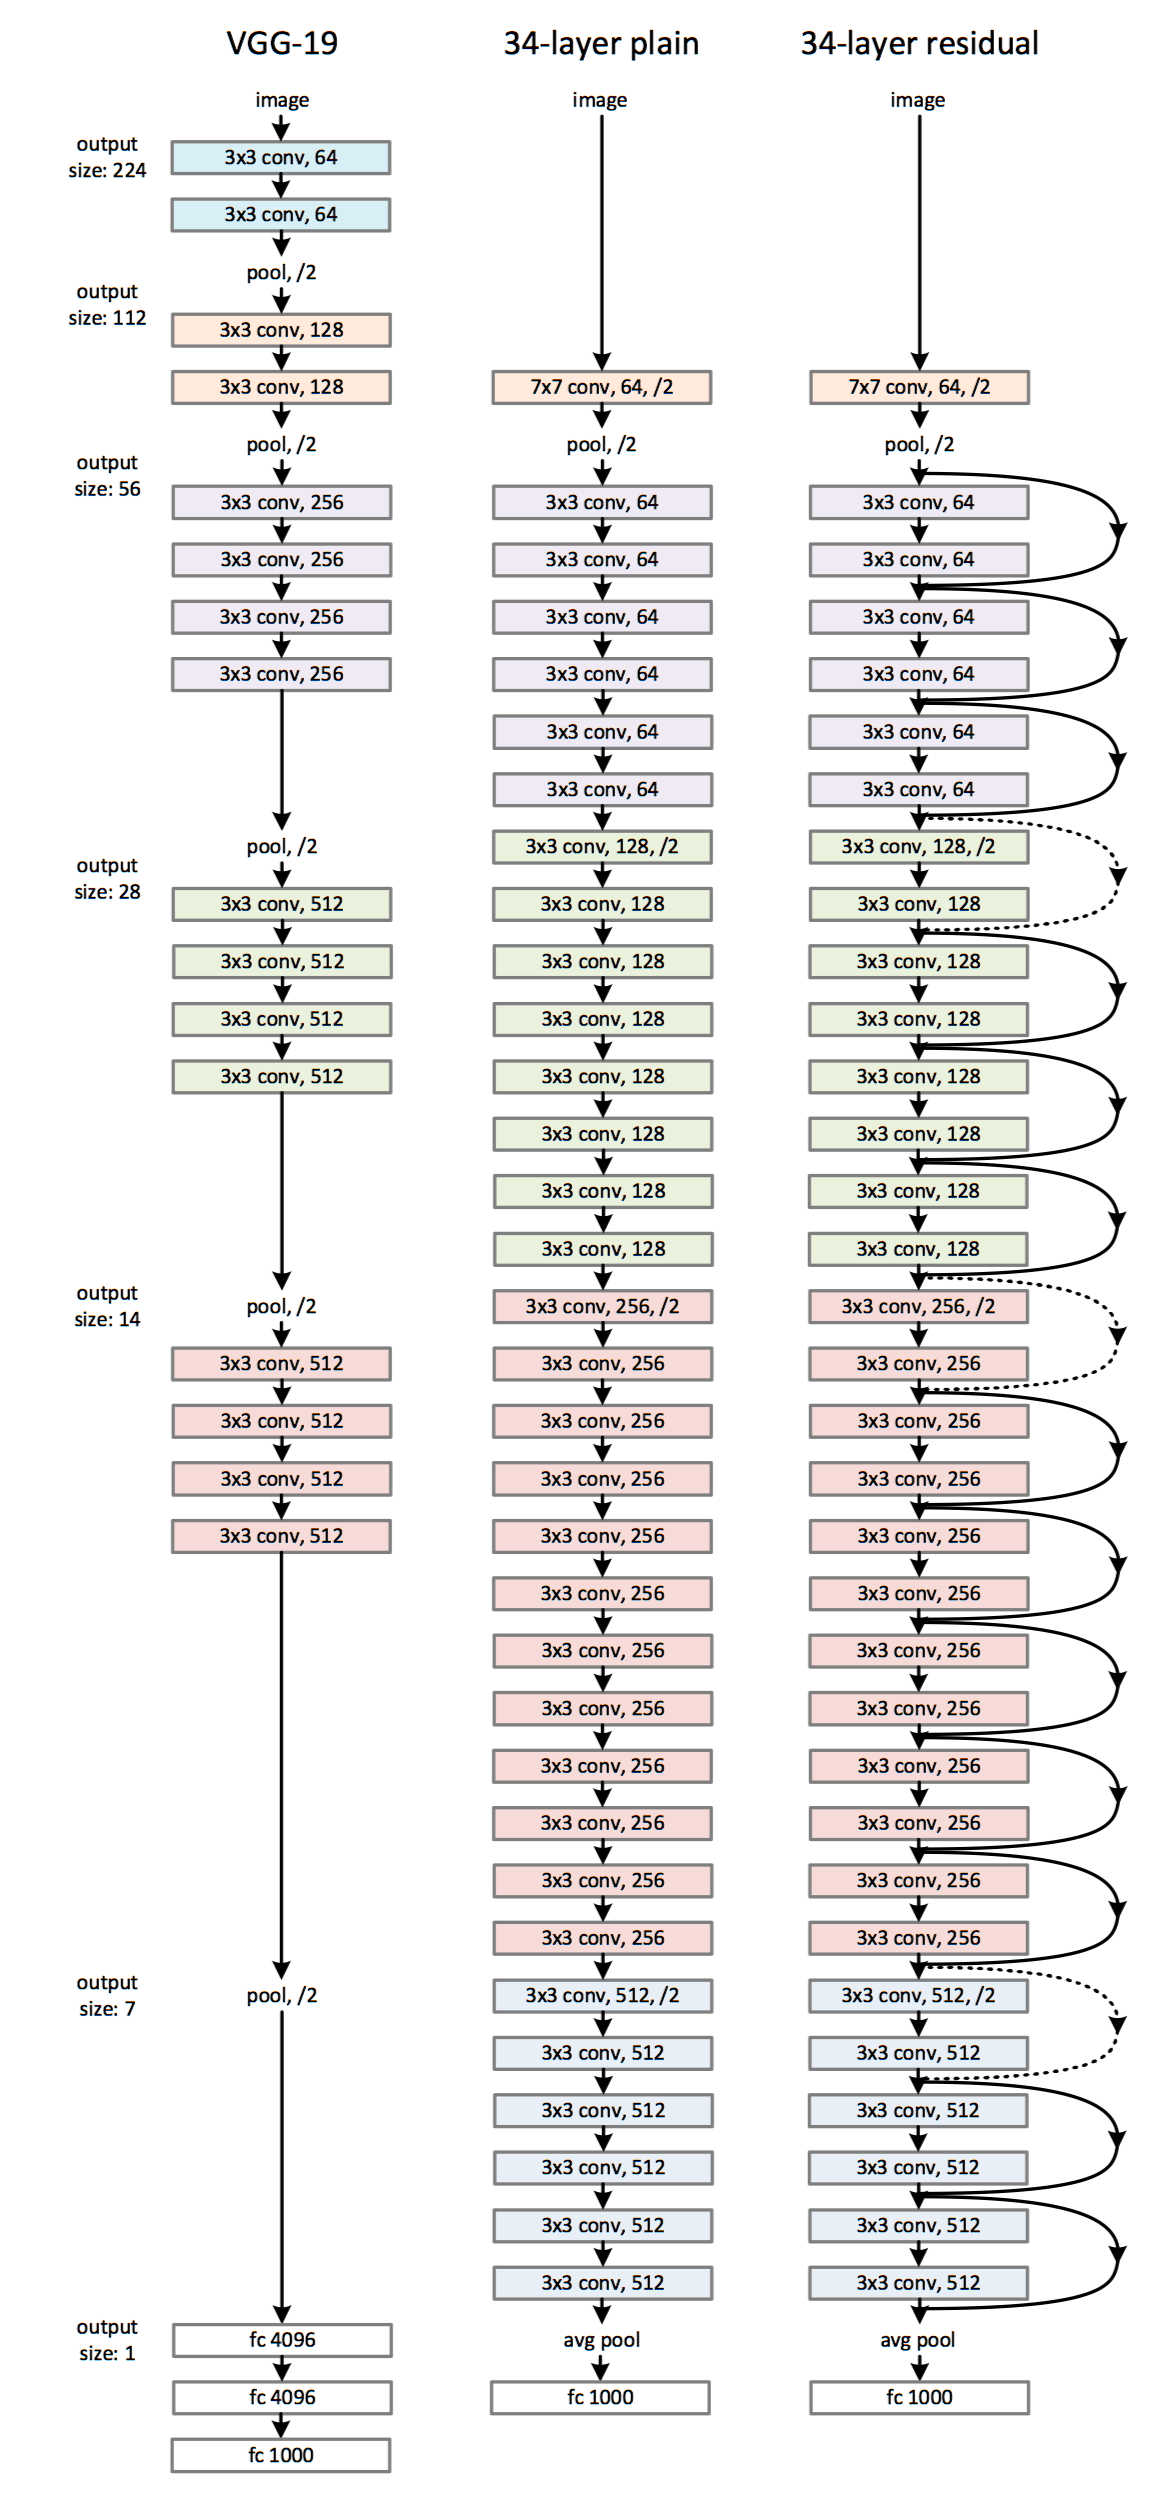

In [1]:
import torch
import torch.nn as nn

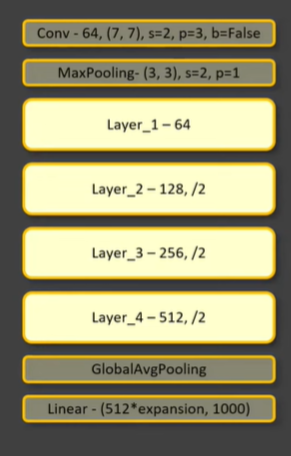


In [22]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, 
                     out_channels, 
                     kernel_size=(3, 3), 
                     stride=stride, 
                     padding=1, 
                     bias=False)


def conv1x1(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, 
                     out_channels, 
                     kernel_size=(1, 1), 
                     stride=stride, 
                     bias=False)


Формулы для расчёта карты признаков 

$$H_{out}=\Biggl\lfloor \frac{H_{in}+2\cdot\text{padding[0]}-\text{dilation[0]}\cdot(\text{kernel\_size[0]} - 1) - 1}{\text{stride[0]}} \Biggl\rfloor + 1$$

$$W_{out}=\Biggl\lfloor \frac{W_{in}+2\cdot\text{padding[1]}-\text{dilation[1]}\cdot(\text{kernel\_size[1]} - 1) - 1}{\text{stride[1]}} \Biggl\rfloor + 1$$

### Калькулятор для расчёта размеров карты признаков

In [23]:
padding = [0, 0]
dilation = [0, 0]
kernel_size = [3, 3]
stride = [1, 1]
H_in = 28
W_in = 28

H_out = int((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1 ) -1 )/ stride[0]) + 1
W_out = int((W_in + 2 * padding[1] - dilation[0] * (kernel_size[1] - 1 ) -1 )/ stride[1]) + 1

print(f'H_out = {H_out}')
print(f'W_out = {H_out}')

H_out = 28
W_out = 28


In [46]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        

In [47]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv1x1(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = conv1x1(out_channels, out_channels*self.expansion)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    
    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out
        

In [48]:
class ResNet(nn.Module):
    cfgs = {
        'resnet18': (BasicBlock, [2, 2, 2, 2]),
        'resnet34': (BasicBlock, [3, 4, 6, 3]),
        'resnet50': (Bottleneck, [3, 4, 6, 3]),
        'resnet101': (Bottleneck, [3, 4, 23, 3]),
        'resnet152': (Bottleneck, [3, 8, 36, 3]),
    }


    def __init__(self, name, num_classes=1000):
        super().__init__()
        block, layers = self.cfgs[name]

        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, self.inplanes, (7, 7), stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((3,3), stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AvgPool2d((7, 7))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)

        return out


    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []

        downsample = None
        if stride != 1 or self.inplanes != out_channels * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, out_channels*block.expansion, stride),
                nn.BatchNorm2d(out_channels*block.expansion)
            )

        layers.append(
            block(self.inplanes, out_channels, stride, downsample)
        )
        self.inplanes = out_channels*block.expansion

        for _ in range(1, blocks):
            layers.append(
                block(self.inplanes, out_channels)
            )
        return nn.Sequential(*layers)
    

In [53]:
model = ResNet('resnet34')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tru

In [54]:
inp = torch.rand([1, 3, 224, 224], dtype=torch.float32)
pred = model(inp)
print(pred.shape)

torch.Size([1, 1000])


# Встроенная

In [55]:
import torchvision
from torchvision import models


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
# resnet = models.resnet50()
weight = models.ResNet50_Weights.DEFAULT
resnet = models.resnet50(weights=weight)
# resnet = models.resnet50(weights=DEFAULT) то же что и выше
resnet


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
import os
os.chdir(r'C:\Users\user\Desktop\learn models')

In [75]:
weight.meta['categories']

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [77]:
weight.transforms

functools.partial(<class 'torchvision.transforms._presets.ImageClassification'>, crop_size=224, resize_size=232)

In [78]:
from torchvision.transforms import v2

In [79]:
trans = v2.Compose([
    v2.ToImage(),
    v2.Resize(232),
    v2.CenterCrop(224),
    v2.ToDtype(dtype=torch.float32, scale=32)
])

In [80]:
from PIL import Image
import matplotlib.pyplot as plt

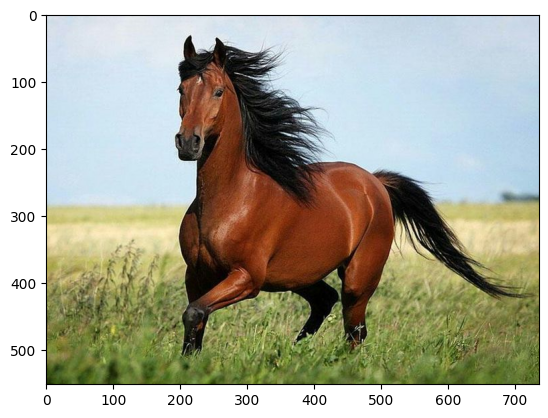

In [87]:
img_name = 'hors.jpg'
img = Image.open(img_name)
plt.imshow(img)


In [91]:
classes = weight.meta['categories']

resnet.eval()
x = trans(img).unsqueeze(dim=0)
pred = resnet(x)

pred = pred.squeeze()

sor, ide = pred.softmax(dim=0).sort(descending=True)

for i, (val, ind) in enumerate(zip(sor, ide)):
    print(f'{classes[ind]} ---> {val:.5f}')
    if i // 5:
        break


sorrel ---> 0.40905
hartebeest ---> 0.00379
muzzle ---> 0.00340
Saluki ---> 0.00281
horse cart ---> 0.00251
rapeseed ---> 0.00224
